In [1]:
!nvidia-smi

Sat May 25 03:16:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              28W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr -q

In [3]:
!pip install --upgrade accelerate
!pip uninstall -y transformers accelerate
!pip install transformers accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 8.8 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.29.3
    Uninstalling accelerate-0.29.3:
      Successfully uninstalled accelerate-0.29.3
Found existing installation: transformers 4.39.3
Uninstalling transformers-4.39.3:
  Successfully uninstalled transformers-4.39.3
Found existing installation: accelerate 0.30.1
Uninstalling accelerate-0.30.1:
  Successfully uninstalled accelerate-0.30.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 1.9 MB/s eta 0:00:00
  Using cached accelerate-0.30.1-py3-none-any.whl.metadata (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 73.7 MB/s eta 0:00:00:00:0100:01
Using cached accelerate-0.30.1-py3-none-any.whl (302 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.3/401.3 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 78.4 MB/s eta 0:00:00:00:01
  Attempting uninstall: huggingface-hub

In [4]:
from transformers import pipeline, set_seed
from datasets import load_dataset, load_from_disk
import matplotlib.pyplot as plt
from datasets import load_dataset
import pandas as pd
from datasets import load_dataset, load_metric

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

import nltk
from nltk.tokenize import sent_tokenize

from tqdm import tqdm
import torch

nltk.download("punkt")

2024-05-25 03:17:44.226182: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-25 03:17:44.226278: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-25 03:17:44.353943: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
model_ckpt = "google/pegasus-cnn_dailymail"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

model_pegasus = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [7]:
import pandas as pd

# Specify file paths
train_file = '/kaggle/input/text-summarization-dataset/combined-text-summarization-dataset/combined-train.csv'
test_file = '/kaggle/input/text-summarization-dataset/combined-text-summarization-dataset/combined-test.csv'
validation_file = '/kaggle/input/text-summarization-dataset/combined-text-summarization-dataset/combined-validation.csv'

# Specify the encoding to read the files
encoding = 'latin1'  # Change this if necessary

# Read and save with UTF-8 encoding
train_df = pd.read_csv(train_file, encoding=encoding)
train_df.to_csv('/kaggle/working/combined-train-utf8.csv', index=False, encoding='utf-8')

test_df = pd.read_csv(test_file, encoding=encoding)
test_df.to_csv('/kaggle/working/combined-test-utf8.csv', index=False, encoding='utf-8')

validation_df = pd.read_csv(validation_file, encoding=encoding)
validation_df.to_csv('/kaggle/working/combined-validation-utf8.csv', index=False, encoding='utf-8')

# Load the preprocessed CSV files into the DatasetDict
data_files = {
    'train': '/kaggle/working/combined-train-utf8.csv',
    'test': '/kaggle/working/combined-test-utf8.csv',
    'validation': '/kaggle/working/combined-validation-utf8.csv'
}

# Load the dataset from the preprocessed CSV files
dataset_ami_corpus_samsum = load_dataset('csv', data_files=data_files)

# Verify the DatasetDict
print(dataset_ami_corpus_samsum)


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['dialogue', 'summary'],
        num_rows: 27192
    })
    test: Dataset({
        features: ['dialogue', 'summary'],
        num_rows: 2319
    })
    validation: Dataset({
        features: ['dialogue', 'summary'],
        num_rows: 1318
    })
})


In [8]:
split_lengths = [len(dataset_ami_corpus_samsum[split])for split in dataset_ami_corpus_samsum]

print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_ami_corpus_samsum['train'].column_names}")
print("\nDialogue:")

print(dataset_ami_corpus_samsum["test"][1]["dialogue"])

print("\nSummary:")

print(dataset_ami_corpus_samsum["test"][1]["summary"])

Split lengths: [27192, 2319, 1318]
Features: ['dialogue', 'summary']

Dialogue:
Eric: MACHINE!
Rob: That's so gr8!
Eric: I know! And shows how Americans see Russian ;)
Rob: And it's really funny!
Eric: I know! I especially like the train part!
Rob: Hahaha! No one talks to the machine like that!
Eric: Is this his only stand-up?
Rob: Idk. I'll check.
Eric: Sure.
Rob: Turns out no! There are some of his stand-ups on youtube.
Eric: Gr8! I'll watch them now!
Rob: Me too!
Eric: MACHINE!
Rob: MACHINE!
Eric: TTYL?
Rob: Sure :)

Summary:
Eric and Rob are going to watch a stand-up on youtube.


In [9]:
def convert_examples_to_features(example_batch):
    # Ensure the inputs are in the correct format (list of strings)
    dialogues = [str(dialogue) for dialogue in example_batch['dialogue']]
    summaries = [str(summary) for summary in example_batch['summary']]

    # Tokenize inputs
    input_encodings = tokenizer(dialogues, max_length=1024, truncation=True)

    # Tokenize targets
    target_encodings = tokenizer(text_target=summaries, max_length=128, truncation=True)

    return {
        'input_ids': input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }

# Apply the function to the dataset
dataset_ami_corpus_samsum_pt = dataset_ami_corpus_samsum.map(convert_examples_to_features, batched=True)


Map:   0%|          | 0/27192 [00:00<?, ? examples/s]

Map:   0%|          | 0/2319 [00:00<?, ? examples/s]

Map:   0%|          | 0/1318 [00:00<?, ? examples/s]

In [10]:
dataset_ami_corpus_samsum_pt["train"]

Dataset({
    features: ['dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 27192
})

In [11]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [12]:
# Training

from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_pegasus)

In [13]:
from transformers import TrainerCallback

class MetricLoggerCallback(TrainerCallback):
    def __init__(self):
        self.metrics = {'eval_loss': [], 'epoch': []}

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics:
            self.metrics['eval_loss'].append(metrics.get('eval_loss'))
            self.metrics['epoch'].append(state.epoch)

# Create an instance of the custom callback
metric_logger = MetricLoggerCallback()

In [14]:
from transformers import TrainingArguments, Trainer

trainer_args = TrainingArguments(
    output_dir='pegasus-ami-corpus-samsum', num_train_epochs=8, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [15]:
trainer = Trainer(model=model_pegasus, args=trainer_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_ami_corpus_samsum_pt["train"],
                  eval_dataset=dataset_ami_corpus_samsum_pt["validation"])

In [16]:
trainer.train()

Step,Training Loss,Validation Loss
500,1.485100,1.403887
1000,1.406100,1.319286
1500,1.467400,1.288858
2000,1.249400,1.270331
2500,1.309900,1.253234
3000,1.296100,1.242596
3500,1.212800,1.240873
4000,1.225700,1.232127
4500,1.211400,1.226263
5000,1.185700,1.219124


TrainOutput(global_step=13592, training_loss=1.162744076200062, metrics={'train_runtime': 39278.8779, 'train_samples_per_second': 5.538, 'train_steps_per_second': 0.346, 'total_flos': 1.0226116206165197e+17, 'train_loss': 1.162744076200062, 'epoch': 7.997646366578405})

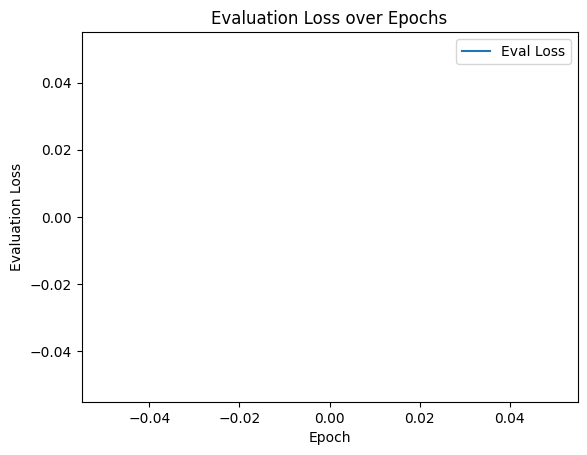

In [18]:
import matplotlib.pyplot as plt

# Plot evaluation loss
plt.plot(metric_logger.metrics['epoch'], metric_logger.metrics['eval_loss'], label='Eval Loss')
plt.xlabel('Epoch')
plt.ylabel('Evaluation Loss')
plt.title('Evaluation Loss over Epochs')
plt.legend()
plt.show()


In [19]:
model_pegasus.save_pretrained("pegasus-samsum-dialogsum-model")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128, 'min_length': 32, 'num_beams': 8, 'length_penalty': 0.8, 'forced_eos_token_id': 1}


In [20]:
## Save tokenizer
tokenizer.save_pretrained("tokenizer")

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/spiece.model',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

In [21]:
# Evaluation

def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]



def calculate_metric_on_test_ds(dataset, metric, model, tokenizer, 
                               batch_size=16, device=device, 
                               column_text="article", 
                               column_summary="highlights"):
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):
        
        inputs = tokenizer(article_batch, max_length=1024,  truncation=True, 
                        padding="max_length", return_tensors="pt")
        
        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device), 
                         length_penalty=0.8, num_beams=8, max_length=128)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''
        
        # Finally, we decode the generated texts, 
        # replace the  token, and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, 
                                clean_up_tokenization_spaces=True) 
               for s in summaries]      
        
        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]
        
        
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
        
    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score

In [22]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_metric = load_metric('rouge')

/tmp/ipykernel_83/2696170338.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric('rouge')
/opt/conda/lib/python3.10/site-packages/datasets/load.py:756: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [24]:
score = calculate_metric_on_test_ds(
    dataset_ami_corpus_samsum['test'], rouge_metric, trainer.model, tokenizer, batch_size = 2, column_text = 'dialogue', column_summary= 'summary'
)

rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = [f'pegasus'] )

100%|██████████| 1160/1160 [29:34<00:00,  1.53s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.01623,0.00024,0.016143,0.016148


In [27]:
#Prediction

gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}



sample_text = dataset_ami_corpus_samsum["test"][0]["dialogue"]

reference = dataset_ami_corpus_samsum["test"][0]["summary"]

pipe = pipeline("summarization", model="pegasus-samsum-dialogsum-model",tokenizer=tokenizer)

## 
print("Dialogue:")
print(sample_text)


print("\nReference Summary:")
print(reference)


print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 128, but your input_length is only 121. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him ????
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Reference Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

Model Summary:
Amanda can't find Betty's number. Larry called her the last time they were at the park together. Hannah wants Amanda to text Larry instead.
